# ZNE with indirect-control VQE
---

This experiment is:

- Qubit: 7, layer: 30
- System has noise-free time evolution.
- Target observable: Transverse field Ising Hamiltonian.
- Ansatz time-evolution: XY, Ising, and Heisenberg Hamiltonians.



## (1) Import and setup

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate

In [2]:
# Set the default font to be LaTeX compliant.
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Computer Modern Roman"
plt.rcParams["text.usetex"] = True

# Set a global font size.
font_size = 11
plt.rcParams["font.size"] = font_size
plt.rcParams["axes.labelsize"] = font_size
plt.rcParams["xtick.labelsize"] = font_size
plt.rcParams["ytick.labelsize"] = font_size
plt.rcParams["legend.fontsize"] = 10

# Others
plot_titles = {
    "xy": "XY ansatz",
    "heisenberg": "Heisenberg ansatz",
    "ising": "Ising ansatz"
}
plot_colors = ["darkred", "darkgreen", "darkblue", "darkmagenta", "darkcyan", "magenta", "green", "goldenrod", "black", "orange", "purple"]
plot_export_names = {
    "xy": "xy_ansatz_noise_free_tevo.eps",
    "heisenberg": "heisenberg_ansatz_noise_free_tevo.eps",
    "ising": "ising_ansatz_noise_free_tevo.eps",
    "compiled": "compiled.eps"
}

## (2) Loading the experimental data from JSON files

The raw experimenal data are availabe at `data\` folder

In [3]:
# Define the paths to the subfolders and the additional JSON file
base_path = "data"
subfolders = ["xy", "ising", "heisenberg"]
various_param_file = os.path.join(base_path, "variousParams.json")

# Initialize a dictionary to store the experimental data
experimental_data: dict = {}
various_param: dict = {}

# Load JSON data from each subfolder and categorize them
for subfolder in subfolders:
    folder_path = os.path.join(base_path, subfolder)
    json_files = [f for f in os.listdir(folder_path) if f.endswith(".json")]
    
    # Categorize files into "redundant" and "zne"
    redundant_files = []
    zne_files = []
    
    for json_file in json_files:
        file_path = os.path.join(folder_path, json_file)
        with open(file_path, "r") as f:
            data = json.load(f)
        
        if "redundant" in json_file.lower():
            redundant_files.append(data)
        elif "zne" in json_file.lower():
            zne_files.append(data)
    
    # Store the categorized data in the dictionary
    experimental_data[subfolder] = {
        "redundant": redundant_files,
        "zne": zne_files
    }

# Load the variousParam.json file
if os.path.exists(various_param_file):
    with open(various_param_file, "r") as f:
        various_param = json.load(f)
else:
    print(f"File {various_param_file} not found.")

## (3) Extracting data

<img src="../../figures/quantum_cicuit_standard_vs_redundant.jpg" alt="std_vs_redun_circuit" width="800"/>


Now lets extract some unformations.




### (A) The exact minimum eigen value

Our target Hamiltonian is

$$H_{Ising} = \sum_{k=1}^{N-1} X_{k}X_{k+1} + \sum_{k=1}^{N}Z_k$$

where $N=7$.

The exact minimum eigen value of the target observable (i.e. tranverse field Ising Hamiltonian for a 7-qubit system) is $-8.566772233505624$. This value is recored in `file_name_prefix_ZNE.json` files.

In [4]:
exact_sol: float = -8.566772233505624
print(f"Exact solution: {exact_sol}")

Exact solution: -8.566772233505624


### (B) VQE estimations (noise is on)

The noise level ($\lambda$) is defined as 
$$\lambda = n_R + 2 n_{CZ} + N n_T + n_Y$$

where $nR, n_{CZ}, n_T, $ and $nY$ are proportinal to number of *noisy* rotation gates, two-qubit $CZ$ gate, the time-evolution gates, and Y gates. For the above circuit in the standard circuit (i.e. unboosted noise) noise level is $6$ while in the redundant circuit (i.e. boosted noise) noise level is $18$.

In [ ]:
noise_levels: int=[6, 18]
extrapolated_noise: int = 0

In [6]:
# Extract sampled data arrays for both XY and Heisenberg ansätze
xy_sampled_data = [entry["output"]["zne_values"]["sampled data"] for entry in experimental_data["xy"]["zne"]]
heisenberg_sampled_data = [entry["output"]["zne_values"]["sampled data"] for entry in experimental_data["heisenberg"]["zne"]]

# Compute noisy VQE statistics
noisy_vqe_vals: dict = {
    "xy": {
        "mean": [
            np.mean([sample[0][4] for sample in xy_sampled_data]),  # Unboosted (noise level 4)
            np.mean([sample[1][4] for sample in xy_sampled_data]),  # Boosted (noise level 18)
        ],
        "std": [
            np.std([sample[0][4] for sample in xy_sampled_data]),   # Unboosted
            np.std([sample[1][4] for sample in xy_sampled_data]),   # Boosted
        ],
    },
    "heisenberg": {
        "mean": [
            np.mean([sample[0][4] for sample in heisenberg_sampled_data]),  # Unboosted
            np.mean([sample[1][4] for sample in heisenberg_sampled_data]),  # Boosted
        ],
        "std": [
            np.std([sample[0][4] for sample in heisenberg_sampled_data]),   # Unboosted
            np.std([sample[1][4] for sample in heisenberg_sampled_data]),   # Boosted
        ],
    },
}
# Lets print the values as well
# Labels
headers = ["Ansatz", "Noise Level", "Mean", "Std Dev"]

# Data rows
rows = [
    ["xy", "Unboosted (noise 4)", noisy_vqe_vals["xy"]["mean"][0], noisy_vqe_vals["xy"]["std"][0]],
    ["xy", "Boosted (noise 18)",  noisy_vqe_vals["xy"]["mean"][1], noisy_vqe_vals["xy"]["std"][1]],
    ["heisenberg", "Unboosted (noise 4)", noisy_vqe_vals["heisenberg"]["mean"][0], noisy_vqe_vals["heisenberg"]["std"][0]],
    ["heisenberg", "Boosted (noise 18)",  noisy_vqe_vals["heisenberg"]["mean"][1], noisy_vqe_vals["heisenberg"]["std"][1]],
]

# Print table
print(tabulate(rows, headers=headers, floatfmt=".6f", tablefmt="grid"))

+------------+---------------------+-----------+-----------+
| Ansatz     | Noise Level         |      Mean |   Std Dev |
+============+=====================+===========+===========+
| xy         | Unboosted (noise 4) | -7.448974 |  0.138941 |
+------------+---------------------+-----------+-----------+
| xy         | Boosted (noise 18)  | -5.992472 |  0.202928 |
+------------+---------------------+-----------+-----------+
| heisenberg | Unboosted (noise 4) | -6.453399 |  0.240208 |
+------------+---------------------+-----------+-----------+
| heisenberg | Boosted (noise 18)  | -5.048399 |  0.201367 |
+------------+---------------------+-----------+-----------+


### (C) ZNE means and standard deviations

The results of two-point Richardson extrapolation:

In [7]:
zne_vals: dict = {
    "xy": {
        "mean": np.mean([entry["output"]["zne_values"]["extrapolated_value"] for entry in experimental_data["xy"]["zne"]]),
        "std": np.std([entry["output"]["zne_values"]["extrapolated_value"] for entry in experimental_data["xy"]["zne"]]),
    },
    "heisenberg": {
        "mean": np.mean([entry["output"]["zne_values"]["extrapolated_value"] for entry in experimental_data["heisenberg"]["zne"]]),
        "std": np.std([entry["output"]["zne_values"]["extrapolated_value"] for entry in experimental_data["heisenberg"]["zne"]]),
    },
}
# Labels for ZNE table
zne_headers = ["Ansatz", "ZNE Extrapolated Mean", "ZNE Std Dev"]

# Data rows
zne_rows = [
    ["xy", zne_vals["xy"]["mean"], zne_vals["xy"]["std"]],
    ["heisenberg", zne_vals["heisenberg"]["mean"], zne_vals["heisenberg"]["std"]],
]

# Print ZNE table
print(tabulate(zne_rows, headers=zne_headers, floatfmt=".6f", tablefmt="grid"))

+------------+-------------------------+---------------+
| Ansatz     |   ZNE Extrapolated Mean |   ZNE Std Dev |
+============+=========================+===============+
| xy         |               -8.177226 |      0.109760 |
+------------+-------------------------+---------------+
| heisenberg |               -7.155899 |      0.273985 |
+------------+-------------------------+---------------+


### (D) VQE estimations when noise is turned-off

If we turn-off the noise in the circuit, the estimations are:

In [8]:
noise_off_vqe_vals: dict ={
    "xy": {
        "mean": np.mean(various_param["important_params"]["xy_ansatz"]["noise_off_estimations"]),
        "std": np.std(various_param["important_params"]["xy_ansatz"]["noise_off_estimations"]),
    },
    "heisenberg": {
        "mean": np.mean(various_param["important_params"]["heisenberg_ansatz"]["noise_off_estimations"]),
        "std": np.std(various_param["important_params"]["heisenberg_ansatz"]["noise_off_estimations"]),
    },
}
# Labels for Noise-Off VQE table
noise_off_headers = ["Ansatz", "Noise-Free VQE Mean", "Noise-Free VQE Std Dev"]

# Data rows for Noise-Off VQE
noise_off_rows = [
    ["xy", noise_off_vqe_vals["xy"]["mean"], noise_off_vqe_vals["xy"]["std"]],
    ["heisenberg", noise_off_vqe_vals["heisenberg"]["mean"], noise_off_vqe_vals["heisenberg"]["std"]],
]

# Print Noise-Off VQE table
print(tabulate(noise_off_rows, headers=noise_off_headers, floatfmt=".6f", tablefmt="grid"))

+------------+-----------------------+--------------------------+
| Ansatz     |   Noise-Free VQE Mean |   Noise-Free VQE Std Dev |
+============+=======================+==========================+
| xy         |             -8.152228 |                 0.137418 |
+------------+-----------------------+--------------------------+
| heisenberg |             -7.388700 |                 0.111762 |
+------------+-----------------------+--------------------------+


## (4) Plot

Finally we can plot the results.

### (A) XY ansatz plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


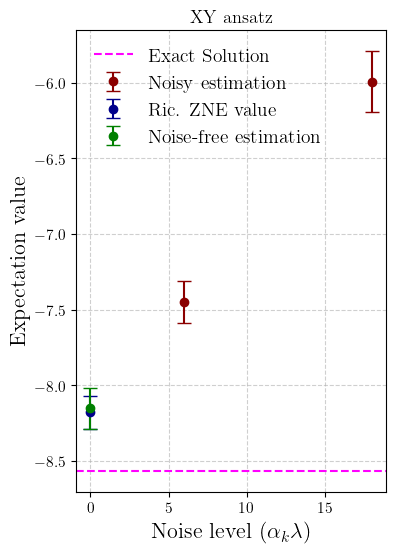

Figure saved as (in 'plots' folder): xy_ansatz_noise_free_tevo.eps


In [9]:
# Plot size
plt.figure(figsize=(4, 6))

# Noisy estimation
plt.errorbar(
    x=noise_levels,
    y=noisy_vqe_vals["xy"]["mean"],
    yerr=noisy_vqe_vals["xy"]["std"], 
    fmt="o", 
    ecolor=plot_colors[0],
    capsize=5, 
    label="Noisy estimation", 
    color=plot_colors[0]
)
# Extrapolated
plt.errorbar(
    x=extrapolated_noise, 
    y=zne_vals["xy"]["mean"], 
    yerr=zne_vals["xy"]["std"], 
    fmt="o", 
    ecolor=plot_colors[2],
    capsize=5, 
    label="Ric. ZNE value", 
    color=plot_colors[2]
)
# Noise-free 
plt.errorbar(
    x=0, 
    y=noise_off_vqe_vals["xy"]["mean"], 
    yerr=noise_off_vqe_vals["xy"]["std"], 
    fmt="o", 
    ecolor=plot_colors[6],
    capsize=5, 
    label="Noise-free estimation", 
    color=plot_colors[6]
)
# Exact solution
plt.axhline(y=exact_sol, color=plot_colors[5], linestyle="--", label=f"Exact Solution")

# Labels and title
plt.xlabel(r"Noise level ($\alpha_k\lambda$)", fontsize=16)
plt.ylabel("Expectation value", fontsize=16)
plt.title(plot_titles["xy"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="upper left", fontsize=14, frameon=False)
# Save as eps
plt.savefig(f"plots/{plot_export_names['xy']}", format="eps")
plt.show()
print("Figure saved as (in 'plots' folder):", plot_export_names["xy"])

### (B) Heisenberg ansatz plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


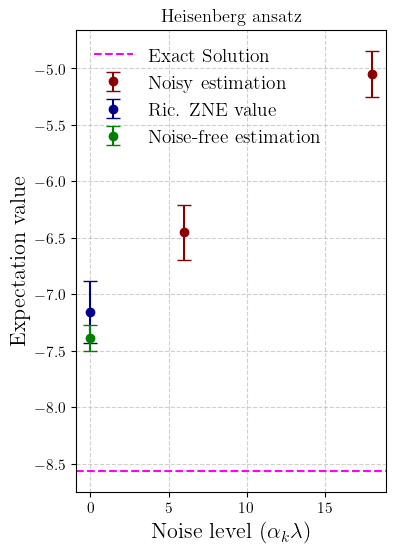

Figure saved as (in 'plots' folder): {'heisenberg_ansatz_noise_free_tevo.eps'}


In [10]:
# Plot size
plt.figure(figsize=(4, 6))

# Noisy estimation
plt.errorbar(
    x=noise_levels,
    y=noisy_vqe_vals["heisenberg"]["mean"],
    yerr=noisy_vqe_vals["heisenberg"]["std"], 
    fmt="o", 
    ecolor=plot_colors[0],
    capsize=5, 
    label="Noisy estimation", 
    color=plot_colors[0]
)
# Extrapolated
plt.errorbar(
    x=extrapolated_noise, 
    y=zne_vals["heisenberg"]["mean"], 
    yerr=zne_vals["heisenberg"]["std"], 
    fmt="o", 
    ecolor=plot_colors[2],
    capsize=5, 
    label="Ric. ZNE value", 
    color=plot_colors[2]
)
# Noise-free 
plt.errorbar(
    x=0, 
    y=noise_off_vqe_vals["heisenberg"]["mean"], 
    yerr=noise_off_vqe_vals["heisenberg"]["std"], 
    fmt="o", 
    ecolor=plot_colors[6],
    capsize=5, 
    label="Noise-free estimation", 
    color=plot_colors[6]
)
# Exact solution
plt.axhline(y=exact_sol, color=plot_colors[5], linestyle="--", label=f"Exact Solution")

# Labels and title
plt.xlabel(r"Noise level ($\alpha_k\lambda$)", fontsize=16)
plt.ylabel("Expectation value", fontsize=16)
plt.title(plot_titles["heisenberg"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="upper left", fontsize=14, frameon=False)
# Save as eps
plt.savefig(f"plots/{plot_export_names['heisenberg']}", format="eps")
plt.show()
print("Figure saved as (in 'plots' folder):", {plot_export_names['heisenberg']})

## (5) Compiled plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


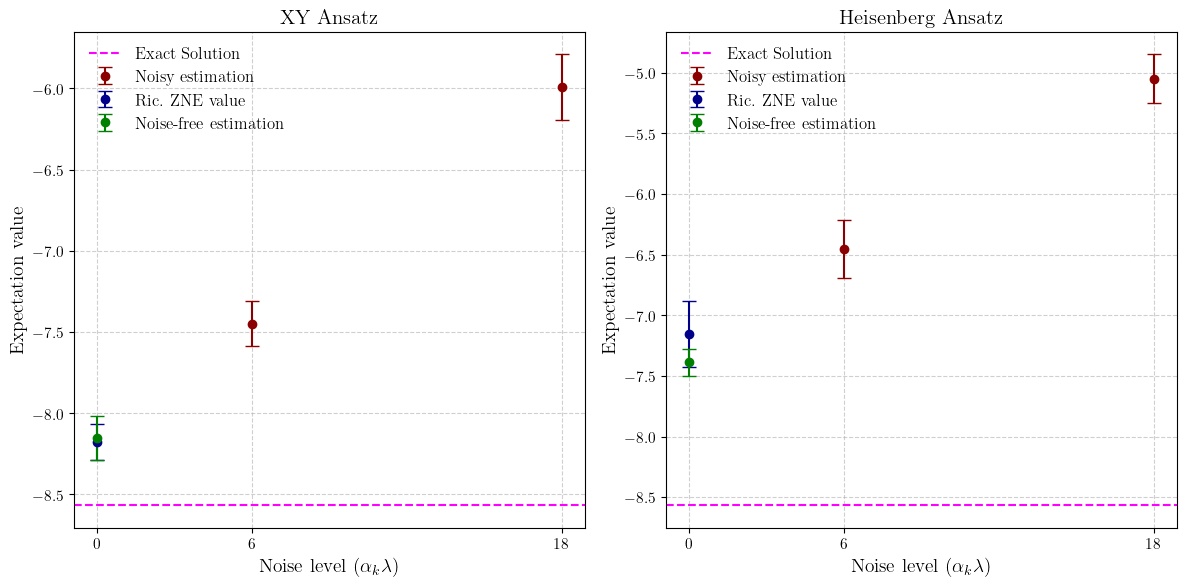

Figure saved as (in 'plots' folder): compiled.eps


In [11]:
# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize for wider plots

# XY plot (first subplot)
axes[0].errorbar(
    x=noise_levels,
    y=noisy_vqe_vals["xy"]["mean"],
    yerr=noisy_vqe_vals["xy"]["std"],
    fmt="o",
    ecolor=plot_colors[0],
    capsize=5,
    label="Noisy estimation",
    color=plot_colors[0],
)
axes[0].errorbar(
    x=extrapolated_noise,
    y=zne_vals["xy"]["mean"],
    yerr=zne_vals["xy"]["std"],
    fmt="o",
    ecolor=plot_colors[2],
    capsize=5,
    label="Ric. ZNE value",
    color=plot_colors[2],
)
axes[0].errorbar(
    x=extrapolated_noise,
    y=noise_off_vqe_vals["xy"]["mean"],
    yerr=noise_off_vqe_vals["xy"]["std"],
    fmt="o",
    ecolor=plot_colors[6],
    capsize=5,
    label="Noise-free estimation",
    color=plot_colors[6],
)
axes[0].axhline(
    y=exact_sol,
    color=plot_colors[5],
    linestyle="--",
    label="Exact Solution",
)
axes[0].set_xlabel(r"Noise level ($\alpha_k\lambda$)", fontsize=14)
axes[0].set_ylabel("Expectation value", fontsize=14)
axes[0].set_title("XY Ansatz", fontsize=15)
axes[0].grid(True, linestyle="--", alpha=0.6)
axes[0].legend(loc="upper left", fontsize=12, frameon=False)
axes[0].set_xticks([extrapolated_noise] + noise_levels)

# Heisenberg plot (second subplot)
axes[1].errorbar(
    x=noise_levels,
    y=noisy_vqe_vals["heisenberg"]["mean"],
    yerr=noisy_vqe_vals["heisenberg"]["std"],
    fmt="o",
    ecolor=plot_colors[0],
    capsize=5,
    label="Noisy estimation",
    color=plot_colors[0],
)
axes[1].errorbar(
    x=extrapolated_noise,
    y=zne_vals["heisenberg"]["mean"],
    yerr=zne_vals["heisenberg"]["std"],
    fmt="o",
    ecolor=plot_colors[2],
    capsize=5,
    label="Ric. ZNE value",
    color=plot_colors[2],
)
axes[1].errorbar(
    x=extrapolated_noise,
    y=noise_off_vqe_vals["heisenberg"]["mean"],
    yerr=noise_off_vqe_vals["heisenberg"]["std"],
    fmt="o",
    ecolor=plot_colors[6],
    capsize=5,
    label="Noise-free estimation",
    color=plot_colors[6],
)
axes[1].axhline(
    y=exact_sol,
    color=plot_colors[5],
    linestyle="--",
    label="Exact Solution",
)
axes[1].set_xlabel(r"Noise level ($\alpha_k\lambda$)", fontsize=14)
axes[1].set_ylabel("Expectation value", fontsize=14)
axes[1].set_title("Heisenberg Ansatz", fontsize=15)
axes[1].grid(True, linestyle="--", alpha=0.6)
axes[1].legend(loc="upper left", fontsize=12, frameon=False)
axes[1].set_xticks([extrapolated_noise] + noise_levels)

# Adjust layout and display
plt.tight_layout()

# Save figure (optional)
plt.savefig(f"plots/{plot_export_names['compiled']}", format="eps")
plt.show()

print("Figure saved as (in 'plots' folder):", plot_export_names['compiled'])
